In [1]:
# import libraries
install.packages('infotheo')
install.packages('keras')
install.packages('MLmetrics')
install.packages("mltools")
install.packages("corrplot")
install.packages("randomForest")
library(dplyr)
library(ggplot2)
library(mltools)
library(data.table)
library(corrplot)
library(infotheo)
library(rpart)
library(tidyr)
library(randomForest)
library(keras)
library(MLmetrics)
print('All libraries are loaded')

Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'infotheo' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'infotheo'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\jeanc\AppData\Local\R\win-library\4.2\00LOCK\infotheo\libs\x64\infotheo.dll to C:\Users\jeanc\AppData\Local\R\win-library\4.2\infotheo\libs\x64\infotheo.dll: Permission denied"
Warning message:
"restored 'infotheo'"



The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages


Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'keras' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages


Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'MLmetrics' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages


Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'mltools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages


Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'corrplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages


Installing package into 'C:/Users/jeanc/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'randomForest' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'randomForest'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\jeanc\AppData\Local\R\win-library\4.2\00LOCK\randomForest\libs\x64\randomForest.dll to C:\Users\jeanc\AppData\Local\R\win-library\4.2\randomForest\libs\x64\randomForest.dll: Permission denied"
Warning message:
"restored 'randomForest'"



The downloaded binary packages are in
	C:\Users\jeanc\AppData\Local\Temp\RtmpARP7Ez\downloaded_packages



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'mltools' was built under R version 4.2.3"

Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


Warning message:
"package 'corrplot' was built under R version 4.2.3"
corrplot 0.92 loaded

Warning message:
"package 'rpart' was built under R version 4.2.3"

Attaching package: 'tidyr'


The following object is masked from 'package:mltools':

    replace_na


Warning message:
"package 'randomForest' was built under R version 4.2.3"
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Warning message:
"package 

[1] "All libraries are loaded"


# Richter's Predictor: Modeling Earthquake Damage
Modeling how different variables affect the odds of different damage outcomes to buildings after the 2015 Gorkha earthquake in Nepal

by: <u>Jean-Christophe Gaudreau</u> and <u>Yuri Antonelli</u>

In [2]:
# We first need to import the train labels and values file

trainset=read.csv("train_labels.csv")
trainvalues=read.csv("train_values.csv")

Here are the different functions that will be utilized for testing the our predictions

In [3]:
ConfusionMatrix <- function(y_pred, y_true) {
  Confusion_Mat <- table(y_true, y_pred)
  return(Confusion_Mat)
}
 
ConfusionDF <- function(y_pred, y_true) {
  Confusion_DF <- transform(as.data.frame(ConfusionMatrix(y_pred, y_true)),
                            y_true = as.character(y_true),
                            y_pred = as.character(y_pred),
                            Freq = as.integer(Freq))
  return(Confusion_DF)
}
 
Precision_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FP <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # it may happen that a label is never predicted (missing from y_pred) but exists in y_true
    # in this case ConfusionDF will not have these lines and thus the simplified code crashes
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]))
   
    # workaround:
    # i don't want to change ConfusionDF since i don't know if the current behaviour is a feature or a bug.
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
   
    tmp <- Confusion_DF[which(Confusion_DF$y_true!=positive & Confusion_DF$y_pred==positive), "Freq"]
    FP[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Precision_micro <- sum(TP) / (sum(TP) + sum(FP))
  return(Precision_micro)
}
 
Recall_micro <- function(y_true, y_pred, labels = NULL) {
  Confusion_DF <- ConfusionDF(y_pred, y_true)
 
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred))
  # this is not bulletproof since there might be labels missing (in strange cases)
  # in strange cases where they existed in training set but are missing from test ground truth and predictions.
 
  TP <- c()
  FN <- c()
  for (i in c(1:length(labels))) {
    positive <- labels[i]
   
    # short version, comment out due to bug or feature of Confusion_DF
    # TP[i] <- as.integer(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"])
    # FP[i] <- as.integer(sum(Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]))
   
    # workaround:
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred==positive), "Freq"]
    TP[i] <- if (length(tmp)==0) 0 else as.integer(tmp)
 
    tmp <- Confusion_DF[which(Confusion_DF$y_true==positive & Confusion_DF$y_pred!=positive), "Freq"]
    FN[i] <- if (length(tmp)==0) 0 else as.integer(sum(tmp))
  }
  Recall_micro <- sum(TP) / (sum(TP) + sum(FN))
  return(Recall_micro)
}
 
F1_Score_micro <- function(y_true, y_pred, labels = NULL) {
  if (is.null(labels) == TRUE) labels <- unique(c(y_true, y_pred)) # possible problems if labels are missing from y_*
  Precision <- Precision_micro(y_true, y_pred, labels)
  Recall <- Recall_micro(y_true, y_pred, labels)
  F1_Score_micro <- 2 * (Precision * Recall) / (Precision + Recall)
  return(F1_Score_micro)
}

# 1. Data preprocessing
Lets first implement a preprocessing model to remove unnecessary data and filter categorical data

## 1.1 Exploratory Data Analysis

In [4]:
head(trainset)
dim(trainset)

,building_id,damage_grade
,<int>,<int>
1,802906,3
2,28830,2
3,94947,3
4,590882,2
5,201944,3
6,333020,2


[1] 260601      2

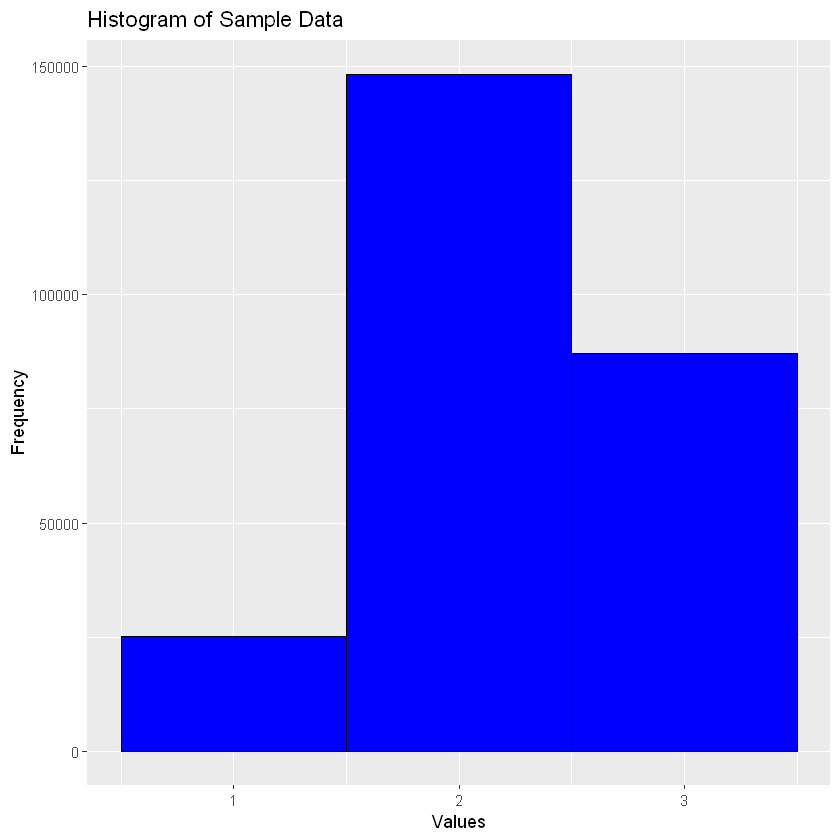

In [5]:
#Let's plot the histogramme of the target variable- damage_grade
ggplot(trainset, aes(x = damage_grade)) + 
  geom_histogram(binwidth = 1, fill = "blue", color = "black") + 
  ggtitle("Histogram of Sample Data") + 
  xlab("Values") + 
  ylab("Frequency")

## 1.2 Transforming categorical data into binary encoding (One-Hot)
+Matching training feature and training target datasets, by "building_id"

In [6]:
# Matching Label data ton Values data to have as many datapoints for both CSVs
master <- left_join(y=trainset,x=trainvalues,by="building_id",all.x=TRUE)
# Removing any rows with NA values
master = drop_na(master)

Here, we have a list of all available categorical data. Although geo_level IDs are integers, they are also considered as categorical since each IDs represents a different house, and there is no visible linear behavior between each ID. Therefore, we can encode <u>**geo_level_1_id**</u> with One-hot without encountering difficulties with the dimensions of our dataset ($\approx$ 30 columns). We decided to leave out <u>**geo_level_id 2-3**</u> due to this complexity problem (for now...).

In [7]:
head(master[c("geo_level_1_id", "geo_level_2_id", "geo_level_3_id")])


,geo_level_1_id,geo_level_2_id,geo_level_3_id
,<int>,<int>,<int>
1,6,487,12198
2,8,900,2812
3,21,363,8973
4,22,418,10694
5,11,131,1488
6,8,558,6089


One-hot encoding is not really an option in this situation since geo_levels_3_id, which range from 0 to 12567, could induce high-dimensionality and sparse data with one-hot, therefore requiring more and more preprocessing.

In [8]:



cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
"other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id")
# use dummyVars function to create binary encoding for categorical variables
master_encoded <- master
head(master_encoded)
# Loop through the categorical columns and encode each column
for (col in cat_cols) {
  dict <- unique(master[[col]])
  binary_matrix <- matrix(0L, nrow = nrow(master), ncol = length(dict))
  for (i in 1:length(dict)) {
    binary_matrix[master[[col]] == dict[i], i] <- 1L
  }
  colnames(binary_matrix) <- paste0(col, "_", dict)
  master_encoded <- cbind(master_encoded, binary_matrix)
}

# Remove the original categorical columns from the new dataframe
master_encoded <- master_encoded[, !colnames(master_encoded) %in% cat_cols]


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,⋯,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,802906,6,487,12198,2,30,6,5,t,r,⋯,0,0,0,0,0,0,0,0,0,3
2,28830,8,900,2812,2,10,8,7,o,r,⋯,0,0,0,0,0,0,0,0,0,2
3,94947,21,363,8973,2,10,5,5,t,r,⋯,0,0,0,0,0,0,0,0,0,3
4,590882,22,418,10694,2,10,6,5,t,r,⋯,0,0,0,0,0,0,0,0,0,2
5,201944,11,131,1488,3,30,8,9,t,r,⋯,0,0,0,0,0,0,0,0,0,3
6,333020,8,558,6089,2,10,9,5,t,r,⋯,0,0,0,0,0,0,0,0,0,2


### Feature Selection
Our dataset is characterized by a large number of variables, therefore we need a way to select the most relevant for our problem.
We use a ranking algorithm based on the mutual information criterium.

In [9]:
# delete the building_id and the damage_grade features
df_train2 = copy(master_encoded)
df_train2$building_id = NULL
df_train2$damage_grade = NULL

# dataframe to store the results
mi_df = data.frame(matrix(nrow = length(colnames(df_train2)), ncol = 1))
rownames(mi_df) = colnames(df_train2)
colnames(mi_df) = 'Mutual_Information'

for (i in 1:length(df_train2)){
    a = mutinformation(df_train2[ ,i], master_encoded$damage_grade)
    mi_df[i, 1] = a
    mi_df <- arrange(mi_df, desc(Mutual_Information))
    
}

# results
head(mi_df)

,Mutual_Information
,<dbl>
geo_level_3_id,0.33412254
geo_level_2_id,0.24000209
foundation_type_r,0.06294687
ground_floor_type_v,0.05233678
has_superstructure_mud_mortar_stone,0.04921463
geo_level_1_id_17,0.04396153


## 1.3 Visualisation of data
Here are the key stats from each columns in the dataset to have more information and see outlyers


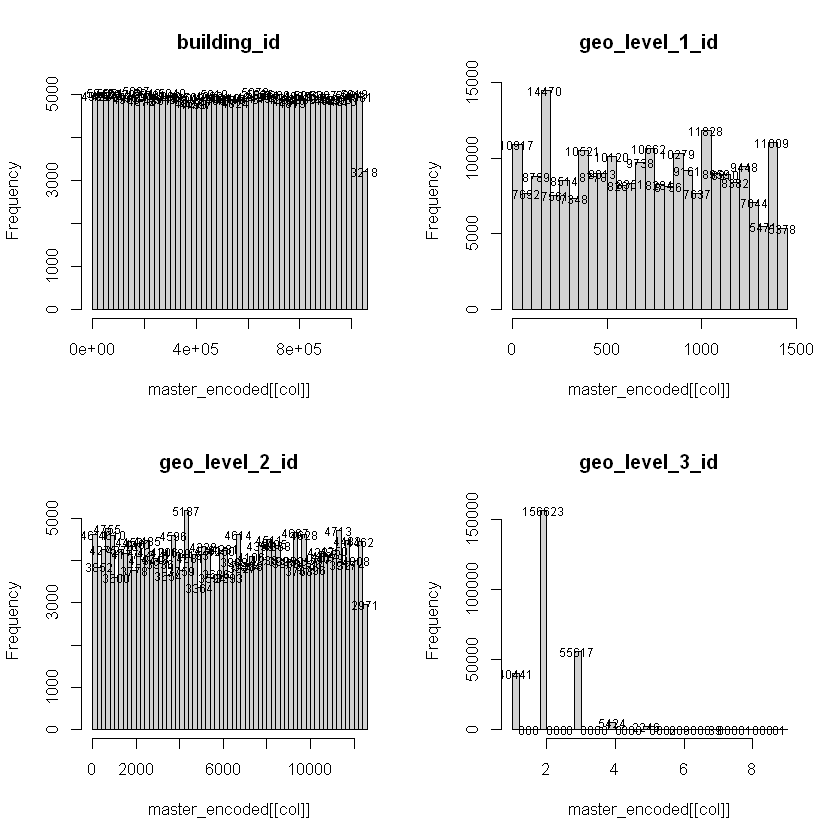

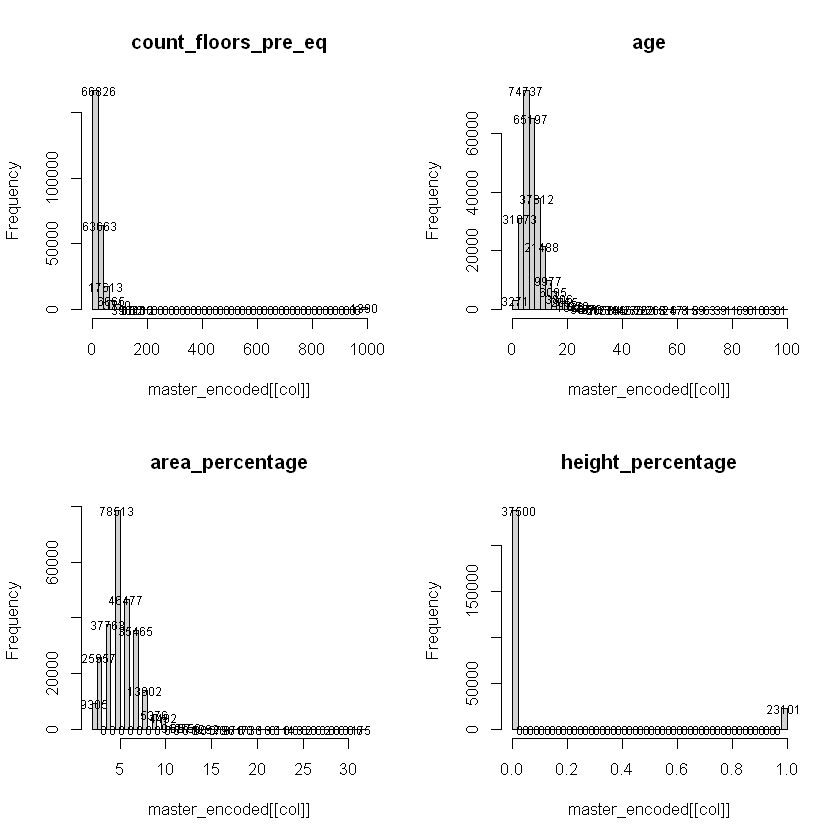

In [10]:
# Set up the plot window to display 2 x 2 plots
par(mfrow = c(2, 2))

# Loop through each column of the data and plot the histogram
for (col in 1:8) {
  y <- hist(master_encoded[[col]], plot = FALSE, breaks = 50)
  plot(y, ylim = c(0, max(y$count) + 5), main = colnames(master)[col])
  text(y$mids, y$counts + 3, y$counts, cex = 0.75)
}

# Reset the plot window to the default layout
par(mfrow = c(1, 1))


Since geo levels are considered as categorical values, we cannot really implement them directly as integers in our models. Indeed, there's no scale difference between an id of 30 or 2000, hence the need to modify and encode this data. Using one-hot encoding could lead to problems in the long run since geo_id_3 has a lot of dimensions. The new dataset would have **thousands** of columns. To fix this, we could create a binary encoding method that could describe values more easily, with fewer columns.

### Optional!!!

In [11]:
#feature engineering geo_level_2_id and geo_level_3_id

Let's write a function which compare the F1_score_micro metric depending on the number of features chosen, taking into account the ranking previously shown

## 2. Model Selection
In this section we are going to train different models taking into account different sets of features, with the aim to select the best options to tackle our problem. In particular, considering the ranking previously created, we are going to add one feature each time and which model perform the best.

The 3 models that we are going to use, from the simplest to the most complex, are:
1. decision tree
2. random forest
3. neural network

Given the huge dimension of the dataset, we are going to assess the quality of the models by means of a classic train-validation split, since cross-validation would be computationally too expensive.

In [12]:
# Train-Test split
train_prop = 0.25

# calculate the number of rows to use for training
train_size <- round(nrow(master_encoded) * train_prop)

# Shuffle the rows of the dataset
set.seed(123)
data_shuffled <- master_encoded[sample(nrow(master_encoded)),]

# Split the shuffled data into training and test sets
train_data <- data_shuffled[1:train_size,]
test_data <- data_shuffled[(train_size+1):nrow(data_shuffled),]

# results
head(train_data)
dim(train_data)
head(test_data)
dim(test_data)

,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,⋯,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
182735,23555,749,11087,2,10,12,5,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
188942,848406,996,7719,3,50,7,6,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
134058,562045,1411,12035,2,10,22,7,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
124022,491150,349,5322,2,80,9,5,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
160997,12219,463,4692,2,20,10,4,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
226318,880155,1050,11785,2,0,6,5,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 65150   100

,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,⋯,geo_level_1_id_5,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
232322,914947,533,4386,4,50,17,8,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
145814,235351,956,9026,3,35,15,6,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
43407,201218,39,2005,2,5,12,6,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
88058,350558,144,2765,2,30,7,4,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
241740,913677,173,3647,1,5,5,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
135,714885,1196,2198,3,15,7,6,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 195451    100

In [13]:

feature_sel = function(max_n, model){
   max_n_features = max_n
    my_index <- which(colnames(train_data) == "damage_grade")
    names = rownames(mi_df)

    # create the dataframe
    indexes_features = c()
    performance_df = data.frame(matrix(nrow = max_n_features, ncol = 2))
    colnames(performance_df) = c('train_perf', 'test_perf')
    rownames(performance_df) = 1:max_n_features

    for (i in 1:max_n_features){
        n = which(colnames(train_data) == names[i])
        indexes_features[i] = n
        train = train_data[ ,indexes_features]
        test = test_data[ ,indexes_features]
        train$damage_grade = as.factor(as.character(train_data$damage_grade))
        test$damage_grade = as.factor(as.character(test_data$damage_grade))
        
        if (i >= 2){
            if (model == 'dec_tree'){
                # Train a decision tree model on the training data
                tree_model <- rpart(damage_grade ~ ., data = train)

                # Predict the labels for the training and test sets
                train_pred <- predict(tree_model, train, type = "class")
                test_pred <- predict(tree_model, test_data, type = "class")

                # Calculate the accuracy of the model on the training and test sets
                train_acc <- F1_Score_micro(train$damage_grade, train_pred)
                test_acc <- F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
            if (model == 'rand_for'){
                # Train a decision tree model on the training data
                rf_model <- randomForest(damage_grade ~ ., data = train, ntree = 200)

                # Predict the labels for the training and test sets
                train_pred <- predict(rf_model, newdata = train[ ,1:i])
                test_pred <- predict(rf_model, newdata = test)

                # Calculate the accuracy of the model on the training and test sets
                train_acc = F1_Score_micro(train$damage_grade, train_pred)
                test_acc = F1_Score_micro(test$damage_grade, test_pred)

                # store the results
                performance_df[i, 1] = train_acc
                performance_df[i, 2] = test_acc 
            }
        }
    }
    head(performance_df)
    plot(performance_df$train_perf, type='l', col=1)
    lines(rownames(performance_df), performance_df$test_perf, col="#e40b0b",lty=2)
}

### 2.1 Decision Tree

In [14]:

# feature_sel(20, 'dec_tree')

### 2.2 Random Forest

In [15]:
# feature_sel(20, 'rand_for')

In [16]:
str(train_data)

'data.frame':	65150 obs. of  100 variables:
 $ building_id                           : int  23555 848406 562045 491150 12219 880155 798723 769353 836519 569417 ...
 $ geo_level_2_id                        : int  749 996 1411 349 463 1050 770 832 728 1414 ...
 $ geo_level_3_id                        : int  11087 7719 12035 5322 4692 11785 2702 2055 9659 5064 ...
 $ count_floors_pre_eq                   : int  2 3 2 2 2 2 1 2 1 3 ...
 $ age                                   : int  10 50 10 80 20 0 0 20 0 0 ...
 $ area_percentage                       : int  12 7 22 9 10 6 11 5 2 15 ...
 $ height_percentage                     : int  5 6 7 5 4 5 4 3 3 7 ...
 $ has_superstructure_adobe_mud          : int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_stone   : int  1 1 0 1 1 0 1 1 0 0 ...
 $ has_superstructure_stone_flag         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_cement_mortar_stone: int  0 0 0 0 0 0 0 0 0 0 ...
 $ has_superstructure_mud_mortar_brick   : int  0

# 3.Neural Network algorithm

In [100]:
train_data$building_id <- NULL
train_data$geo_level_2_id <-NULL
train_data$geo_level_3_id <- NULL

binary_cols <- sapply(train_data, is.logical)
numeric_cols <- sapply(train_data, is.numeric)



model <- keras_model_sequential() %>%
  layer_dense(units = 64, activation = "relu", input_shape = ncol(train_data)-1) %>%
  layer_dense(units = 32, activation = "relu") %>%
  layer_dense(units = 3, activation = "softmax")

model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "adam",
  metrics = c("accuracy")
)
#Set last column as the variable we want to predict (damage_grade)
train_data %>% relocate(damage_grade, .after = last_col())


history <- model %>% fit(
  x = as.matrix(train_data[, -ncol(train_data)]),
  y = to_categorical(train_data$damage_grade - 1),
  epochs = 10,
  batch_size = 32,
  validation_split = 0.2
)

save_model_hdf5(model, "path_to_save_model.h5")

,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,⋯,geo_level_1_id_15,geo_level_1_id_14,geo_level_1_id_19,geo_level_1_id_1,geo_level_1_id_24,geo_level_1_id_28,geo_level_1_id_23,geo_level_1_id_2,geo_level_1_id_29,damage_grade
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
182735,2,10,12,5,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
188942,3,50,7,6,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
134058,2,10,22,7,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
124022,2,80,9,5,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2
160997,2,20,10,4,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
226318,2,0,6,5,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
103065,1,0,11,4,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
124507,2,20,5,3,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
199365,1,0,2,3,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2


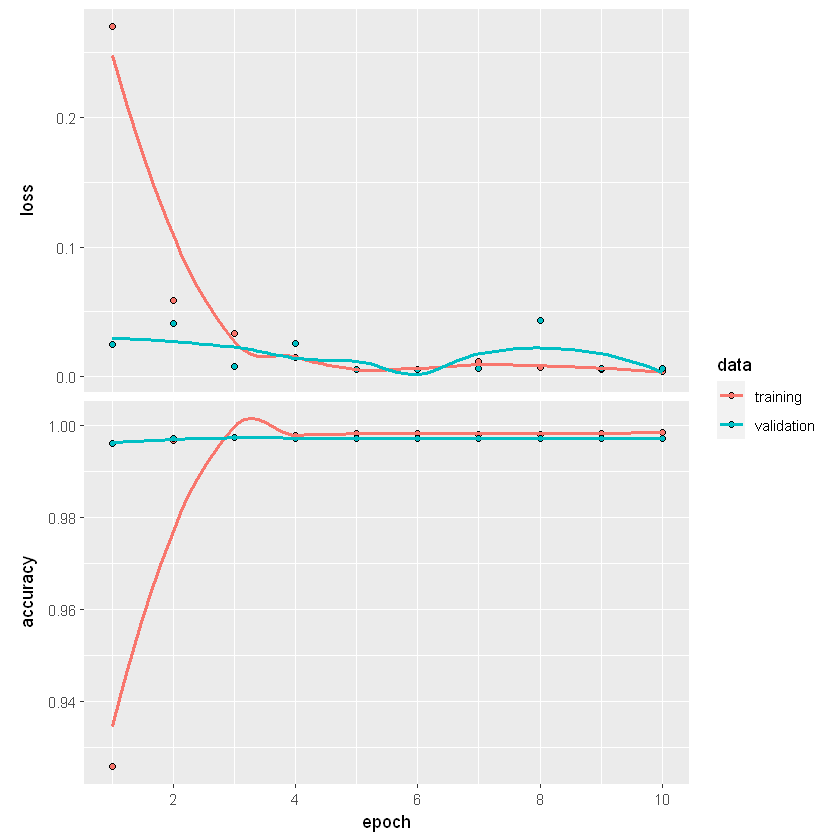

In [101]:
plot(history,col.hidden = 'darkgreen',     
col.hidden.synapse = 'darkgreen',
     show.weights = F,
     information = F,
     fill = 'lightblue')

In [102]:
summary(train_data)

 count_floors_pre_eq      age         area_percentage  height_percentage
 Min.   :1.000       Min.   :  0.00   Min.   : 1.000   Min.   : 2.00    
 1st Qu.:2.000       1st Qu.: 10.00   1st Qu.: 5.000   1st Qu.: 4.00    
 Median :2.000       Median : 15.00   Median : 7.000   Median : 5.00    
 Mean   :2.128       Mean   : 25.92   Mean   : 7.998   Mean   : 5.43    
 3rd Qu.:2.000       3rd Qu.: 30.00   3rd Qu.: 9.000   3rd Qu.: 6.00    
 Max.   :7.000       Max.   :995.00   Max.   :90.000   Max.   :32.00    
 has_superstructure_adobe_mud has_superstructure_mud_mortar_stone
 Min.   :0.00000              Min.   :0.000                      
 1st Qu.:0.00000              1st Qu.:1.000                      
 Median :0.00000              Median :1.000                      
 Mean   :0.08666              Mean   :0.763                      
 3rd Qu.:0.00000              3rd Qu.:1.000                      
 Max.   :1.00000              Max.   :1.000                      
 has_superstructure_stone_f

## 3.1 Preprocessing pipeline
Here, we use a similar way of implementing Neural network, just for any type of dataset


In [103]:
#Submissions format
sub=read.csv("test_values.csv")

cat_cols=c('land_surface_condition', 'foundation_type',"roof_type","ground_floor_type",
"other_floor_type","position","plan_configuration","legal_ownership_status","geo_level_1_id")
# use dummyVars function to create binary encoding for categorical variables
master_submit <- sub

# Loop through the categorical columns and encode each column
for (col in cat_cols) {
  dict <- unique(sub[[col]])
  binary_matrix <- matrix(0L, nrow = nrow(sub), ncol = length(dict))
  for (i in 1:length(dict)) {
    binary_matrix[sub[[col]] == dict[i], i] <- 1L
  }
  colnames(binary_matrix) <- paste0(col, "_", dict)
  master_submit <- cbind(master_submit, binary_matrix)
}

# Remove the original categorical columns from the new dataframe
master_submit <- master_submit[, !colnames(master_submit) %in% cat_cols]
buildin_ids <- master_submit$building_id
master_submit$building_id <- NULL
master_submit$geo_level_2_id <-NULL
master_submit$geo_level_3_id <- NULL




## 3.2 Applying Neural-Network algorithm

In [ ]:
model <- load_model_hdf5("path_to_save_model.h5")
master_submit <- as.matrix(master_submit)
predictions <- predict(model, master_submit)
predicted_damage_grade <- max.col(predictions) + 1
#Formating csv for submission_format
df <- data.frame (building_id=buildin_ids,
                  damage_grade=predicted_damage_grade
                  )


In [104]:
write.csv(df,"prediction.csv", row.names=FALSE)